# Tips

These are some tips for the data scientist practioner.

## Control ticks

It might be annoying that the default x- and y-axis tick labels are coarsed grained. Take the example below; the x- and y-axis ticks are even numbered. What if we want more granularity and also show all whole numbers?

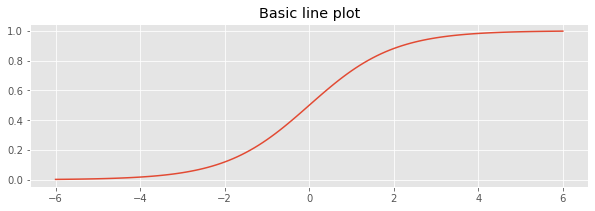

In [1]:
from scipy.special import expit as logistic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(37)
plt.style.use('ggplot')

x = np.arange(-6, 6.1, 0.1)
y = logistic(x)
s = pd.Series(y, x)

fig, ax = plt.subplots(figsize=(10, 3))

_ = s.plot.line(x, y, ax=ax)
_ = ax.set_title('Basic line plot')

Use the `set_xticks()` and `set_yticks()` functions to control the ticks on the x- and y-axis.

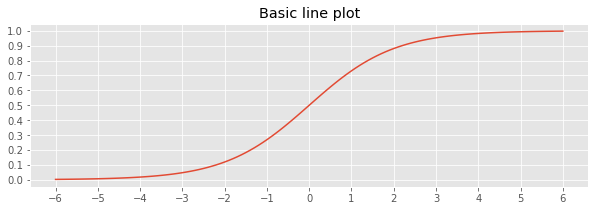

In [2]:
fig, ax = plt.subplots(figsize=(10, 3))

_ = s.plot.line(x, y, ax=ax)
_ = ax.set_title('Basic line plot')
_ = ax.set_xticks(np.arange(-6, 6.1, 1))
_ = ax.set_yticks(np.arange(0, 1.1, 0.1))

## Multi-class, average precision score

In multi-class classification, your `y_true` (truth labels) might be a 1-dimensional vector, but your predictions `y_pred` (especially if you use `predict_proba()`) will be multi-dimensional. The `average_precision_score(y_true, y_pred)` expects that both `y_true` and `y_pred` are multi-dimensional. For example, the following will fail.

```python
y_true = [1, 1, 0, 0, 2, 2]
y_pred = [
    [0.0, 1.0, 0.0], 
    [0.0, 1.0, 0.0], 
    [1.0, 0.0, 0.0], 
    [1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0]
]
average_precision_score(y_true, y_pred) # fails
```

You will need to one-hot encode `y_true`.

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import average_precision_score

y_true = np.array([1, 1, 0, 0, 2, 2])

encoder = OneHotEncoder()
Y = encoder.fit_transform(y_true.reshape(-1, 1)).todense()

y_pred = np.array([
    [0.0, 1.0, 0.0], 
    [0.0, 1.0, 0.0], 
    [1.0, 0.0, 0.0], 
    [1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0]
])

average_precision_score(Y, y_pred)

C:\Users\jeev\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


1.0

## Sorting multi-index

You might have a dataframe that has multi-index for the rows and columns. How do you sort by columns or rows? 

In [4]:
df = pd.DataFrame({
    'height': ['tall', 'tall', 'tall', 'tall', 'short', 'short', 'short', 'short'],
    'weight': ['heavy', 'heavy', 'light', 'light', 'heavy', 'heavy', 'light', 'light'],
    'value': [9.9, 10.0, 7.7, 6.7, 5.5, 6.6, 3.3, 2.3]
})

stats = df.groupby(['height', 'weight']).agg(['mean', 'std'])
stats

value          
               mean       std
height weight                
short  heavy   6.05  0.777817
       light   2.80  0.707107
tall   heavy   9.95  0.070711
       light   7.20  0.707107

To sort based on column multi-index, you have to use `sort_values()` and supply a list of tuples. Below, we will sort by the `mean` and then `std` columns.

In [5]:
stats.sort_values([('value', 'mean'), ('value', 'std')])

value          
               mean       std
height weight                
short  light   2.80  0.707107
       heavy   6.05  0.777817
tall   light   7.20  0.707107
       heavy   9.95  0.070711

To sort based on the row multi-index, it is not as complicated, simply supply a list of index names to `sort_values()`.

In [6]:
stats.sort_values(['weight'], axis=0)

value          
               mean       std
height weight                
short  heavy   6.05  0.777817
tall   heavy   9.95  0.070711
short  light   2.80  0.707107
tall   light   7.20  0.707107

If you need to sort descendingly, pass in `ascending=False`.

In [7]:
stats.sort_values(['weight'], axis=0, ascending=False)

value          
               mean       std
height weight                
short  light   2.80  0.707107
tall   light   7.20  0.707107
short  heavy   6.05  0.777817
tall   heavy   9.95  0.070711

## One-Hot Encoding Pipeline

When you use OHE in a pipeline, you will have to deal with missing values. If you use `SimpleImputer` and fill missing values with a constant value, you will always end up with an extra column. What's worse, the columns corresponding to the categorical values will NOT be missing and instead have 0's. Additionally, your output is a matrix, and you lose the field names. Here's an example dataframe with 2 numeric field (height and age) and 2 categorical fields (pet and color).

In [8]:
df = pd.DataFrame({
    'height': [2.3, 3.3, 2.4, 5.5, np.nan],
    'pet': ['cat', 'dog', 'cat', np.nan, 'dog'],
    'color': ['blue', 'black', np.nan, 'brown', 'black'],
    'age': [10, 5, np.nan, 4, 8]
})

df

,height,pet,color,age
0,2.3,cat,blue,10.0
1,3.3,dog,black,5.0
2,2.4,cat,NaN,NaN
3,5.5,NaN,brown,4.0
4,NaN,dog,black,8.0


Let's say we want to OHE the pet and color fields. See the problems here?

- What happened to the headers?
- The output is a matrix and not a dataframe. 
- We have an additional column.

In [9]:
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
])
transformer = ColumnTransformer(transformers=[('cat', cat_pipeline, ['pet', 'color'])])

pipeline = Pipeline(steps=[
    ('preprocessing', transformer)
])

pipeline.fit_transform(df)

array([[1., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 1., 0.],
       [0., 1., 0., 1., 0., 0., 0.]])

We can try to recover the field names as follows. If we specified for the transformer to passthrough (eg `remainder='passthrough'` the numeric fields, then we have to do even more work to align the field names. It should be apparent that the `_nan` fields are a nuisance and the generic field prefixes of `x0_` and `x1_` are not very helpful.

In [10]:
columns = transformer.named_transformers_['cat'] \
            .named_steps['ohe'] \
            .get_feature_names_out()
pd.DataFrame(pipeline.transform(df), columns=columns)

,x0_cat,x0_dog,x0_nan,x1_black,x1_blue,x1_brown,x1_nan
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0


So, what can we do? We can create a custom transformer to fix the problem. Take note of the pattern below. The `OheAdjustmentTransformer` is the custom transformer that takes in the `ColumnTransformer`; the former needs the latter to retrieve the OHE fields. Also, notice the dizzying nested structures of 

- pipelines within pipelines,
- transformers within pipelines, and
- pipelines within transformers.

The final output is a little bit better since

- the field names are more meaningful (they have the original field names as prefixes instead of `x0_`),
- the `_nan` columns are dropped,
- the records for which there should be missing values instead of 0's are corrected, and
- if we choose to pass through the numeric fields, then they are also available.

In [11]:
class OheAdjustmentTransformer:
    def __init__(self, transformer, num_columns, cat_columns, missing_suffix='nan'):
        self.transformer = transformer
        self.num_columns = num_columns
        self.cat_columns = cat_columns
        self.missing_suffix = missing_suffix
        
    def adjust(self, df):
        def make_null(d, cat_field, nan_field):
            n_df = pd.DataFrame()
            for field in d.columns:
                if field == nan_field:
                    continue
                u_index = field.find('_')
                val = field[u_index+1:]
                n_field = f'{cat_field}_{val}'
                n_df[n_field] = np.select([d[nan_field]==1], [np.nan], default=d[field])
            
            n_df.index = d.index
            return n_df
                
        prefixes = [f'x{i}_' for i in range(len(self.cat_columns))]
        c2p = {c: p for c, p in zip(self.cat_columns, prefixes)}
        c2n = {c: f'{p}nan' for c, p in zip(self.cat_columns, prefixes)}
        df_cols = {c: [f for f in df.columns if f.startswith(p)] 
                   for c, p in zip(self.cat_columns, prefixes)}
        dfs = {c: df[df_cols[c]] for c in df_cols}
        n_dfs = {c: make_null(d, c, c2n[c]) for c, d in dfs.items()}
        f_df = pd.concat([d for d in n_dfs.values()], axis=1)
        
        return f_df
        
    def fit(self, X=None, y=None):
        return self
    
    def transform(self, X):
        cat_columns = self.transformer.named_transformers_['cat'] \
            .named_steps['ohe'] \
            .get_feature_names_out()
        cat_columns = list(cat_columns)
        num_columns = self.num_columns
        
        if X.shape[1] == len(cat_columns):
            columns = cat_columns
        else:
            columns = cat_columns + num_columns
            
        df = pd.DataFrame(X, columns=columns)
        
        if X.shape[1] == len(cat_columns):
            return self.adjust(df)
        else:
            return self.adjust(df).join(df[num_columns])

cat_columns = ['pet', 'color']
num_columns = [c for c in df.columns if c not in cat_columns]

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

transformer = ColumnTransformer(
    transformers=[('cat', cat_pipeline, cat_columns)], 
    remainder='passthrough')

df_pipeline = Pipeline(steps=[
    ('df', OheAdjustmentTransformer(transformer, num_columns, cat_columns))
])

pipeline = Pipeline(steps=[
    ('preprocessing', transformer),
    ('postprocessing', df_pipeline)
])

pipeline.fit_transform(df)

,pet_cat,pet_dog,color_black,color_blue,color_brown,height,age
0,1.0,0.0,0.0,1.0,0.0,2.3,10.0
1,0.0,1.0,1.0,0.0,0.0,3.3,5.0
2,1.0,0.0,NaN,NaN,NaN,2.4,NaN
3,NaN,NaN,0.0,0.0,1.0,5.5,4.0
4,0.0,1.0,1.0,0.0,0.0,NaN,8.0


## Displaying Pandas Series and DataFrames

Often times, we want to display ALL columns and fields of a Pandas Series or DataFrame. We can set the options in a notebook cell as follows.

```python
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
```

But now, these settings take over all subsequent displays. It's getter to use the Pandas option context manager to temporarily make the settings just for a cell.

```python
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(some_df)
    display(some_series)
```